# Gaussian Process Revenue Forecasting

This notebook implements and tests the Gaussian Process model for daily revenue forecasting, strictly following the specified kernel and feature engineering requirements.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Add project root to path to allow imports
project_root = os.path.abspath("../../../../")
if project_root not in sys.path:
    sys.path.append(project_root)

from src.core.db.connection import get_db_connection
from src.core.learning.revenue_forecasting.gaussianprocess import GaussianProcessForecaster, sample_data
from src.api.routers.forecast import get_historical_data

%matplotlib inline

/Users/kshitijsharma/Documents/projects/analytics/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## 1. Load Data
Fetching real data from the database. If insufficient data exists, falling back to sample data.

In [2]:
conn, _ = get_db_connection()

try:
    df = get_historical_data(conn, start_date="01-11-25", end_date="05-02-26")
    print(f"Loaded {len(df)} rows from database.")
except Exception as e:
    print(f"DB load failed: {e}")
    df = pd.DataFrame()
finally:
    conn.close()

# Fallback to sample data if DB is empty or too small for meaningful GP training
if len(df) < 30:
    print("Not enough real data. Generating synthetic sample data for demonstration.")
    df = sample_data(n=365)

print("Sample rows:")
display(df.tail())

Connecting to database at: /Users/kshitijsharma/Documents/projects/analytics/analytics.db
Loaded 97 rows from database.
Sample rows:


,ds,y,orders,temp_max,rain_sum,weather_code,forecast_snapshot
92,2026-02-01,42174.0,56,20.4,45.5,65,"{""time"": [""2026-02-01"", ""2026-02-02"", ""2026-02..."
93,2026-02-02,20589.0,33,19.4,0.0,3,"{""time"": [""2026-02-02"", ""2026-02-03"", ""2026-02..."
94,2026-02-03,29244.0,47,19.5,0.0,3,"{""time"": [""2026-02-03"", ""2026-02-04"", ""2026-02..."
95,2026-02-04,30144.0,42,19.9,0.0,3,"{""time"": [""2026-02-04"", ""2026-02-05"", ""2026-02..."
96,2026-02-05,27135.0,50,20.8,0.0,1,"{""time"": [""2026-02-05"", ""2026-02-06"", ""2026-02..."


## 2. Train Gaussian Process Model
Initializing the model with the mandatory kernel structure and fitting it to the data.

In [3]:
forecaster = GaussianProcessForecaster()

print("Training GP Model... (this may take a moment)")
forecaster.fit(df, target='y')

print("Training Complete.")

Training GP Model... (this may take a moment)
Optimized kernel:
 0.773**2 * RBF(length_scale=[1.08, 0.101, 0.536, 1.36, 100]) + WhiteKernel(noise_level=0.431)
Training Complete.


## 3. Evaluation
Compute MAE, RMSE, and 95% coverage.

In [4]:
forecaster.evaluate(df, target='y')

MAE=3697.66 RMSE=4829.64 Coverage95=100.00%


## 4. Visualization
Plotting actuals vs predictions with uncertainty intervals.

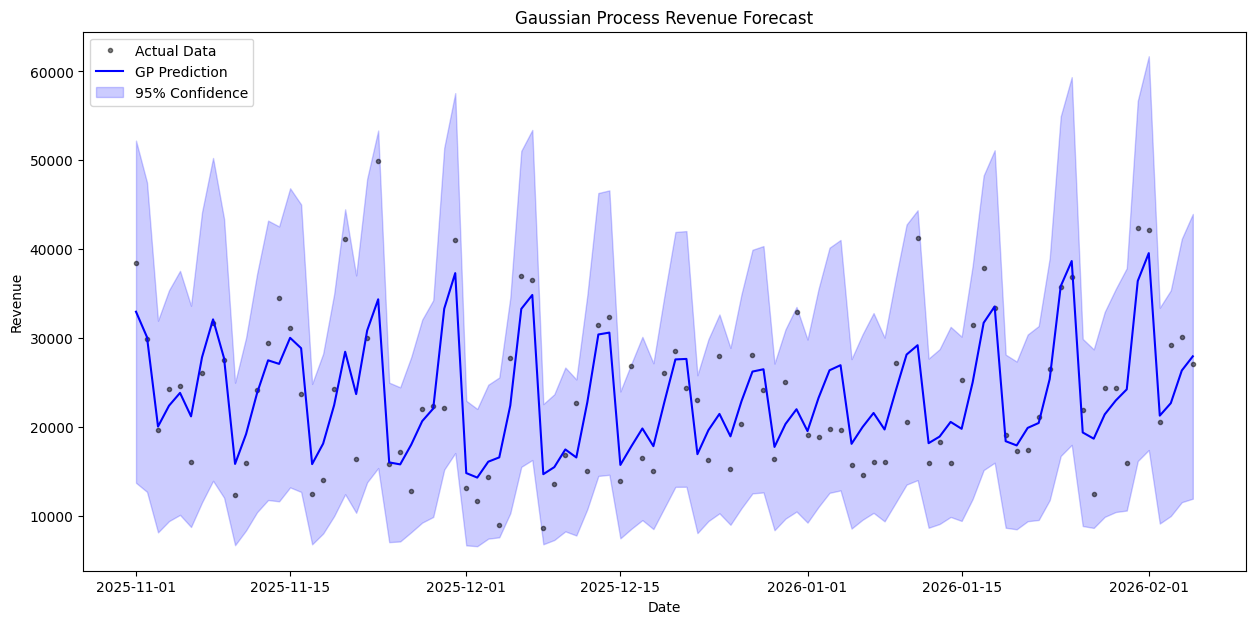

In [5]:
# 1. Get predictions (MODEL NOW RETURNS REVENUE DIRECTLY)
mean, std = forecaster.predict(df)

# 2. Calculate intervals directly (NO np.exp needed)
lower = mean - 1.96 * std
upper = mean + 1.96 * std

# 3. Clean up for plotting
mean = np.nan_to_num(mean, nan=0.0)
lower = np.nan_to_num(lower, nan=0.0)
upper = np.nan_to_num(upper, nan=0.0)

# 4. Plot
plt.figure(figsize=(15, 7))
plt.plot(df['ds'], df['y'], 'k.', label='Actual Data', alpha=0.5)
plt.plot(df['ds'], mean, 'b-', label='GP Prediction')
plt.fill_between(df['ds'], lower, upper, alpha=0.2, color='b', label='95% Confidence')
plt.title("Gaussian Process Revenue Forecast")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()

## 5. Scenario Predictions
Testing specific scenarios as required:
- Hot Summer Saturday
- Cold Winter Monday

In [6]:
# Define Scenarios
scenarios = pd.DataFrame([
    {"ds": pd.Timestamp("2025-06-21"), "temp_max": 42.0, "desc": "Hot Summer Saturday (June 21)"}, # Saturday
    {"ds": pd.Timestamp("2025-01-20"), "temp_max": 5.0,  "desc": "Cold Winter Monday (Jan 20)"}    # Monday
])

pred_mean, pred_std = forecaster.predict(scenarios)

for i, row in scenarios.iterrows():
    m = pred_mean[i]
    s = pred_std[i]
    print(f"\nScenario: {row['desc']}")
    print(f"Date: {row['ds'].date()}, Temp: {row['temp_max']}C")
    print(f"Predicted Revenue: {m:.2f} ± {1.96*s:.2f} (95% CI)")
    print(f"Uncertainty (Std): {s:.2f}")


Scenario: Hot Summer Saturday (June 21)
Date: 2025-06-21, Temp: 42.0C
Predicted Revenue: 23722.26 ± 18126.89 (95% CI)
Uncertainty (Std): 9248.42

Scenario: Cold Winter Monday (Jan 20)
Date: 2025-01-20, Temp: 5.0C
Predicted Revenue: 18480.95 ± 9826.00 (95% CI)
Uncertainty (Std): 5013.27


## 6. Kernel Analysis
Explaining how the kernel parts model business behavior.

In [7]:
print("Learned Kernel:", forecaster.model.kernel_)
print("\nInterpretation:")
print("- RBF Component (dim=2): Captures the smooth, non-linear relationship between temperature and revenue.")
print("- ExpSineSquared (dim=0, Yearly): Captures broad annual seasonality (high in summer, low in winter).")
print("- ExpSineSquared (dim=1, Weekly): Captures the weekly cycle (weekend peaks vs weekday lulls).")
print("- WhiteKernel: Captures random noise/day-to-day variance not explained by calendar or weather.")

Learned Kernel: 0.773**2 * RBF(length_scale=[1.08, 0.101, 0.536, 1.36, 100]) + WhiteKernel(noise_level=0.431)

Interpretation:
- RBF Component (dim=2): Captures the smooth, non-linear relationship between temperature and revenue.
- ExpSineSquared (dim=0, Yearly): Captures broad annual seasonality (high in summer, low in winter).
- ExpSineSquared (dim=1, Weekly): Captures the weekly cycle (weekend peaks vs weekday lulls).
- WhiteKernel: Captures random noise/day-to-day variance not explained by calendar or weather.


## 7. Save Model (Optional)

In [8]:
# forecaster.save('gp_model.joblib')
# print('Model saved.')